# SEGMENTATION OF BANKING CUSTOMERS

## Librery imports

In [64]:
# Entorno y Dependencias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuración opcional de visualización
%matplotlib inline

## Load the data

In [ ]:
#Csv files read
clients = pd.read_csv("../data/clients_welfordbank_en.csv", parse_dates=["Date_Birth", "Registration_Date"]) #Esto es para asegurarnos de que las fechas se interpreten correctamente
accounts = pd.read_csv("../data/accounts_welfordbank_en.csv")
transactions = pd.read_csv("../data/transactions_welfordbank_en.csv", parse_dates=["Transaction_Date"])
cards = pd.read_csv("../data/cards_welfordbank_en.csv")

#Tables size
print("Clients:", clients.shape)
print("Accounts:", accounts.shape)
print("Transactions:", transactions.shape)
print("Cards:", cards.shape)

Clients: (25000, 16)
Accounts: (33775, 14)
Transactions: (1858361, 18)
Cards: (33718, 14)


## Dataframes organization and merge

We normalize the column names and keep the DataFrames with only the necessary data from each table, then merge them all into a single one.


In [ ]:
#Name normalization to facilitate future joins

clients.rename(columns={'Client_ID': 'client_id',
                        'Gender': 'gender',
                        'Country': 'country',
                        'City': 'city',
                        'Date_Birth': 'date_birth',
                        'Customer_Lifetime_Value': 'clv'}, inplace=True)

accounts.rename(columns={'Client_ID': 'client_id',
                         'Account_ID': 'account_id',
                         'Account_Type': 'account_type',
                         'Balance': 'current_balance'}, inplace=True)

transactions.rename(columns={'Client_ID': 'client_id',
                             'Transaction_ID': 'transaction_id',
                             'Account_ID': 'account_id',
                             'Transaction_Date': 'date',
                             'Amount': 'amount'}, inplace=True)

cards.rename(columns={'Client_ID': 'client_id',
                      'Card_ID': 'card_id',
                      'Credit_Limit': 'credit_limit',
                      'Available_Balance': 'available_balance'}, inplace=True)


### Clients metrics

In [ ]:
today = pd.Timestamp('today')

clients['age'] = (today - clients['date_birth']).dt.days // 365 #To calculate age in years

clients_df = clients[['client_id', 'age', 'gender', 'country', 'city', 'clv']] #Save the relevant columns in a new DataFrame

print(clients_df.head())


   client_id  age  gender country      city       clv
0          1   87    Male   Spain  Pamplona  28793.37
1          2   32  Female   Spain  Terrassa  11689.42
2          3   61    Male   Spain   Manacor  14210.90
3          4   62  Female   Spain   Vilalba  19585.72
4          5   62  Female   Spain     Ceuta   9210.93


### Accounts metrics

In [ ]:
account_df = (
    accounts
      .groupby('client_id')
      .agg(num_accounts = ('account_id', 'count'),
           avg_balance = ('current_balance', 'mean'),
           num_account_types = ('account_type', 'nunique'))
      .reset_index()
)

print(account_df.head())


   client_id  num_accounts  avg_balance  num_account_types
0          1             1     26550.58                  1
1          2             1     90755.89                  1
2          3             2    103227.57                  2
3          4             1    130496.18                  1
4          5             2     92951.96                  2


### Transaccions metrics

In [ ]:
trans_df = (
    transactions
      .groupby('client_id')
      .agg(total_txn_count   = ('transaction_id', 'count'),
           avg_txn_amount    = ('amount', 'mean'),
           txn_amount_std    = ('amount', 'std'),
           total_deposits    = ('amount', lambda x: x[x > 0].sum()),
           total_withdrawals = ('amount', lambda x: x[x < 0].sum()))
      .reset_index()
)

print(trans_df.head())

   client_id  total_txn_count  avg_txn_amount  txn_amount_std  total_deposits  \
0          1               18     4488.121111     3952.966488        80786.18   
1          2               90     4123.119444     3491.629566       371080.75   
2          3              159     4147.546792     3790.299080       659459.94   
3          4               69     3317.845072     3566.644900       228931.31   
4          5              120     4191.550000     3808.285769       502986.00   

   total_withdrawals  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  


### Cards metrics

In [ ]:
card_df = (
    cards
      .groupby('client_id')
      .agg(
          num_cards             = ('card_id', 'count'),
          avg_credit_limit      = ('credit_limit', 'mean'),
          avg_available_balance = ('available_balance', 'mean'),
          total_credit_limit    = ('credit_limit', 'sum'),
          total_available_balance = ('available_balance', 'sum')
      )
      .reset_index()
)

#Derivated metric: credit utilization (0-1)
card_df['credit_utilization'] = 1 - (
    card_df['total_available_balance'] / card_df['total_credit_limit'].replace(0, np.nan)
)

print(card_df.head())

   client_id  num_cards  avg_credit_limit  avg_available_balance  \
0          1          1          0.000000               0.000000   
1          2          1          0.000000               0.000000   
2          3          2       3765.600000            1532.375000   
3          4          1       4694.130000            4694.130000   
4          5          3       1440.726667            1440.726667   

   total_credit_limit  total_available_balance  credit_utilization  
0                0.00                     0.00                 NaN  
1                0.00                     0.00                 NaN  
2             7531.20                  3064.75             0.59306  
3             4694.13                  4694.13             0.00000  
4             4322.18                  4322.18             0.00000  


### Merge all the df

In [ ]:
#Merge the dataframes on 'client_id'
data = (clients_df
            .merge(account_df, on='client_id', how='left')
            .merge(trans_df , on='client_id', how='left')
            .merge(card_df, on='client_id', how='left'))

#Refill Na values in numeric columns with 0
num_cols = data.select_dtypes(include='number').columns.drop('client_id')
data[num_cols] = data[num_cols].fillna(0)

print(data.head())
print("Shape:", data.shape)


   client_id  age  gender country      city       clv  num_accounts  \
0          1   87    Male   Spain  Pamplona  28793.37             1   
1          2   32  Female   Spain  Terrassa  11689.42             1   
2          3   61    Male   Spain   Manacor  14210.90             2   
3          4   62  Female   Spain   Vilalba  19585.72             1   
4          5   62  Female   Spain     Ceuta   9210.93             2   

   avg_balance  num_account_types  total_txn_count  avg_txn_amount  \
0     26550.58                  1               18     4488.121111   
1     90755.89                  1               90     4123.119444   
2    103227.57                  2              159     4147.546792   
3    130496.18                  1               69     3317.845072   
4     92951.96                  2              120     4191.550000   

   txn_amount_std  total_deposits  total_withdrawals  num_cards  \
0     3952.966488        80786.18                0.0        1.0   
1     3491.629566 

## Pre-processing before K-Means

### Selection of Numerical and Categorical Columns

In [60]:
# `data` is the full DataFrame obtained by merging all the relevant information.

# • num_cols:   here the numeric variables we want to standardize.
# • cat_cols:   here the categorical variables we want to keep.

num_cols = [
    'age', 'clv',                        
    'num_accounts', 'avg_balance', 'num_account_types',
    'total_txn_count', 'avg_txn_amount', 'txn_amount_std',
    'total_deposits', 'total_withdrawals',
    'num_cards', 'avg_credit_limit',
    'avg_available_balance', 'credit_utilization'
]

#Analyze how many unique categories each variable has
print("Unique categories:")
for col in ['gender', 'country', 'city']:
    print(f"{col}: {data[col].nunique()}")

Unique categories:
gender: 2
country: 1
city: 134


In [61]:
#Decision on categorical variables:
#   • gender   → definitely include (2 categories)
#   • country  → ignore if is only Spain, not relevant for clustering
#   • city     → have too many categories, skip for K-Means
cat_cols = ['gender'] 

### One-Hot Encoding of Categorical Columns

In [62]:
#get_dummies creates 0/1 columnsfor one-hot. drop_first=True avoids multicollinearity.
dummies = pd.get_dummies(data[cat_cols], drop_first=True)

#Concatenate the numeric columns with the dummies
X = pd.concat([data[num_cols], dummies], axis=1)

#Store the names of the columns for later use
data_names = X.columns.tolist()

#Add the dummies to the original data for reference
data = pd.concat([data, dummies], axis=1)

print("Shape with dummies:", X.shape)
print("First rows:\n", X.head())


Shape with dummies: (25000, 15)
First rows:
    age       clv  num_accounts  avg_balance  num_account_types  \
0   87  28793.37             1     26550.58                  1   
1   32  11689.42             1     90755.89                  1   
2   61  14210.90             2    103227.57                  2   
3   62  19585.72             1    130496.18                  1   
4   62   9210.93             2     92951.96                  2   

   total_txn_count  avg_txn_amount  txn_amount_std  total_deposits  \
0               18     4488.121111     3952.966488        80786.18   
1               90     4123.119444     3491.629566       371080.75   
2              159     4147.546792     3790.299080       659459.94   
3               69     3317.845072     3566.644900       228931.31   
4              120     4191.550000     3808.285769       502986.00   

   total_withdrawals  num_cards  avg_credit_limit  avg_available_balance  \
0                0.0        1.0          0.000000            

### Scaling Numerical Variables

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)    #The normalized data is now in X_scaled

#Convert back to DataFrame for inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=data_names, index=data['client_id'])
print("Mean and standard deviation after scaling (≈0 and 1):")
print(pd.DataFrame(X_scaled, columns=data_names).agg(['mean', 'std']).round(2).head())


Mean and standard deviation after scaling (≈0 and 1):
      age  clv  num_accounts  avg_balance  num_account_types  total_txn_count  \
mean -0.0  0.0           0.0         -0.0               -0.0             -0.0   
std   1.0  1.0           1.0          1.0                1.0              1.0   

      avg_txn_amount  txn_amount_std  total_deposits  total_withdrawals  \
mean             0.0             0.0            -0.0                0.0   
std              1.0             1.0             1.0                0.0   

      num_cards  avg_credit_limit  avg_available_balance  credit_utilization  \
mean        0.0               0.0                    0.0                -0.0   
std         1.0               1.0                    1.0                 1.0   

      gender_Male  
mean         -0.0  
std           1.0  


We can see that the scaling was successful.


## K value selection (Elbow and Siluette)

### Elbow Method (Inertia / SSE)

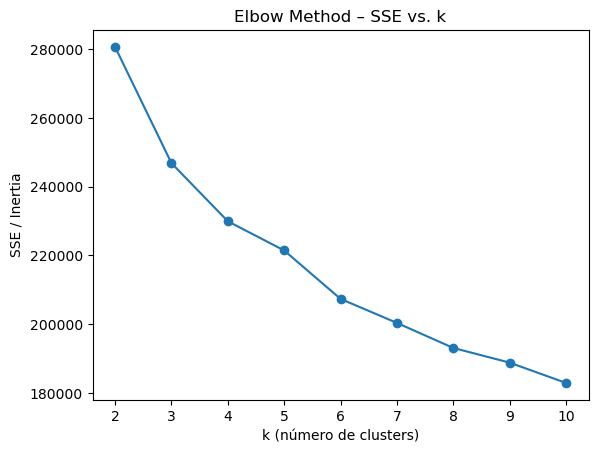

In [ ]:
inertias = []
K_range  = range(2, 11)          #Testing from 2 to 10 clusters
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertias.append(km.inertia_)

#Plotting the elbow method
plt.figure()
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method – SSE vs. k")
plt.xlabel("k (number of clusters)")
plt.ylabel("SSE / Inertia")
plt.show()

Vemos que a partir de 4 clusters se aplana demasiado y eso significa que añadir mas clusters no nos va a reducir la SSE, no cogeremos mas de 4, pero vamos a hacer siluette para elejir el valor mas optimo 2, 3 o 4

### Silhouette Score

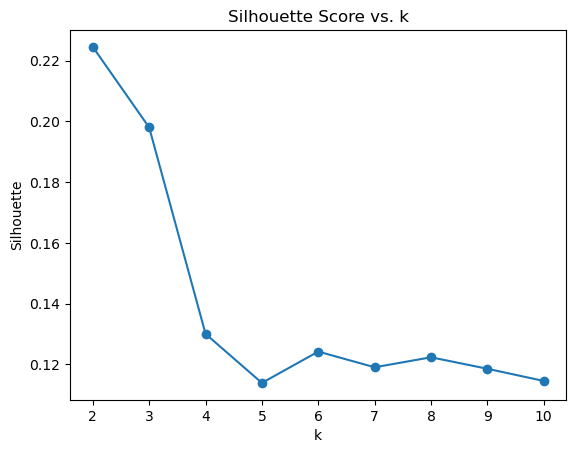

    k  silhouette
0   2    0.224566
1   3    0.198020
2   4    0.130003
3   5    0.113846
4   6    0.124178
5   7    0.119000
6   8    0.122291
7   9    0.118516
8  10    0.114497


In [ ]:
#Computing silhouette scores for each k
silh_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silh_scores.append(score)

#Plotting silhouette scores
plt.figure()
plt.plot(K_range, silh_scores, marker='o')
plt.title("Silhouette Score vs. k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

print(pd.DataFrame({'k': K_range, 'silhouette': silh_scores}))

The maximum silhouette score is at **k = 2** (≈ 0.22), with the second highest at **k = 3** (≈ 0.20). After that, the score drops below 0.15, indicating overlapping clusters.

I choose **k = 2** and **k = 3** because the elbow method suggests selecting 2, 3, or 4 clusters, and the silhouette score points to 2 or 3. I'll try **k = 2** first, and then test **k = 3** to see if it improves the results.


## K-Means

### k=2

In [ ]:
best_k = 2   # k value seleccion 

#Kmeans clustering         
kmeans = KMeans(n_clusters=best_k, random_state=12, n_init='auto')
data['cluster'] = kmeans.fit_predict(X_scaled)

#Numeric summary of the clusters
summary = (
    data
      .groupby('cluster')
      .agg(
          n_customers             = ('client_id', 'count'),
          age_mean                = ('age', 'mean'),
          clv_mean                = ('clv', 'mean'),
          num_accounts_mean       = ('num_accounts', 'mean'),
          txn_count_mean          = ('total_txn_count', 'mean'),
          credit_util_mean        = ('credit_utilization', 'mean'),
          pct_female              = ('gender_Male', lambda x: 1 - x.mean())  
      )
      .round(2)
)
display(summary)

,n_customers,age_mean,clv_mean,num_accounts_mean,txn_count_mean,credit_util_mean,pct_female
cluster,,,,,,,
0,6839,53.05,19908.91,2.18,125.10,0.17,0.6
1,18161,52.80,20029.80,1.04,55.22,0.09,0.6


### k=3

In [ ]:
best_k = 3     # k value seleccion

#Kmeans clustering  
kmeans2 = KMeans(n_clusters=best_k, random_state=12, n_init='auto')
data['cluster'] = kmeans2.fit_predict(X_scaled)

#Numeric summary of the clusters
summary2 = (
    data
      .groupby('cluster')
      .agg(
          n_customers             = ('client_id', 'count'),
          age_mean                = ('age', 'mean'),
          clv_mean                = ('clv', 'mean'),
          num_accounts_mean       = ('num_accounts', 'mean'),
          txn_count_mean          = ('total_txn_count', 'mean'),
          credit_util_mean        = ('credit_utilization', 'mean'),
          pct_female              = ('gender_Male', lambda x: 1 - x.mean())  
      )
      .round(2)
)
display(summary2)

,n_customers,age_mean,clv_mean,num_accounts_mean,txn_count_mean,credit_util_mean,pct_female
cluster,,,,,,,
0,12930,52.85,20045.26,1.04,55.52,0.01,0.61
1,5718,52.68,20015.02,1.11,57.34,0.29,0.59
2,6352,53.09,19881.46,2.20,127.94,0.16,0.60


### First conclusions

**k = 2**: essentially separates **"active clients with more products"** from **"less active clients"**.

**k = 3**: further distinguishes those who heavily use their credit line (**cluster 1**); it leaves one **multi-product, highly active cluster** (**cluster 2**) and one **low-activity cluster** (**cluster 0**).

We select the **k=3**, because we need **more than 2 only groups**.

### Test with k=4

I try with k=4 to have more groups to recomend diferent products.

In [ ]:
best_k = 4        # k value seleccion

#Kmeans clustering   
kmeans3 = KMeans(n_clusters=best_k, random_state=12, n_init='auto')
data['cluster'] = kmeans3.fit_predict(X_scaled)

# Numeric summary of the clusters
summary3 = (
    data
      .groupby('cluster')
      .agg(
          n_customers             = ('client_id', 'count'),
          age_mean                = ('age', 'mean'),
          clv_mean                = ('clv', 'mean'),
          num_accounts_mean       = ('num_accounts', 'mean'),
          txn_count_mean          = ('total_txn_count', 'mean'),
          credit_util_mean        = ('credit_utilization', 'mean'),
          pct_female              = ('gender_Male', lambda x: 1 - x.mean())  
      )
      .round(2)
)
display(summary3)

,n_customers,age_mean,clv_mean,num_accounts_mean,txn_count_mean,credit_util_mean,pct_female
cluster,,,,,,,
0,8116,52.41,19906.31,1.05,58.14,0.02,0.60
1,5046,52.57,20135.94,1.12,59.76,0.28,0.60
2,6249,53.07,19888.34,2.20,128.57,0.17,0.60
3,5589,53.59,20123.51,1.05,50.36,0.04,0.61


### Final conclusions

This model is more useful for **marketing purposes**, but if we want to be more specific, we should avoid using more than **3 clusters**. 

Since the bank’s goal is to use this model for **product recommendations**, and we want to **avoid bothering clients** who are not part of the product's target group, we decide to go with **3 clusters**, the middle point.


### How to Act on Each Segment (`k = 3`)

| Segment                                 | Key Findings                                                                       | Product / Offer Strategy                                                                                                                                                |
| --------------------------------------- | ---------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Low-Engage**<br>(cluster 0)           | - 1 account<br>- 55 tx/year<br>- Credit utilization ≈ 0 %                          | **Activation & basic cross-sell**<br>• No-fee debit/credit card offers<br>• Cash-back on the first 3 purchases<br>• Digital-banking reminders                           |
| **High-Credit-Use**<br>(cluster 1)      | - 1 account<br>- Credit utilization ≈ 29 %<br>- CLV near average                   | **Financing & risk-controlled products**<br>• Responsible credit-limit increase<br>• Pre-approved personal loans<br>• Financial-health alerts (avoid over-indebtedness) |
| **Multi-Product-Active**<br>(cluster 2) | - ≥ 2 accounts<br>- 128 tx/year<br>- Credit utilization ≈ 17 %<br>- Core customers | **Premium / wealth up-sell**<br>• Interest-bearing or investment accounts<br>• Insurance and pension planning<br>• Loyalty perks (VIP cash-back, dedicated advisor)     |

> **tx/year** = transactions per year.
